INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/efficientnet_b4.ra2_in1k)


113040 282


INFO:timm.models._hub:[timm/efficientnet_b4.ra2_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
INFO:timm.models._builder:Missing keys (classifier.weight, classifier.bias) discovered while loading pretrained weights. This is expected if model is being adapted.
100%|██████████| 9/9 [00:01<00:00,  6.22it/s]


train_loss: 0.0801
train_acc: 0.9723
train_f1: 0.9709
val_loss: 0.4813
val_acc: 0.8759
val_f1: 0.8626
preds_list: 282 items
targets_list: 282 items
epoch: 0.0000



100%|██████████| 9/9 [00:01<00:00,  6.10it/s]


train_loss: 0.0147
train_acc: 0.9952
train_f1: 0.9949
val_loss: 0.5468
val_acc: 0.9007
val_f1: 0.8897
preds_list: 282 items
targets_list: 282 items
epoch: 1.0000



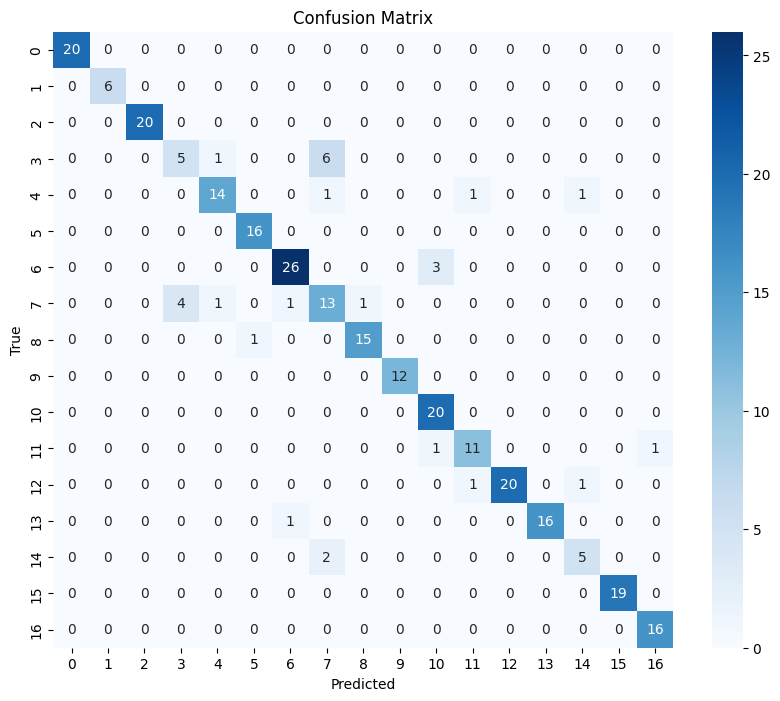

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00        20
           3       0.56      0.42      0.48        12
           4       0.88      0.82      0.85        17
           5       0.94      1.00      0.97        16
           6       0.93      0.90      0.91        29
           7       0.59      0.65      0.62        20
           8       0.94      0.94      0.94        16
           9       1.00      1.00      1.00        12
          10       0.83      1.00      0.91        20
          11       0.85      0.85      0.85        13
          12       1.00      0.91      0.95        22
          13       1.00      0.94      0.97        17
          14       0.71      0.71      0.71         7
          15       1.00      1.00      1.00        19
          16       0.94      1.00      0.97        16

   

In [14]:
import os
import time

import timm
import torch
import albumentations as A
import pandas as pd
import numpy as np
import torch.nn as nn
from albumentations.pytorch import ToTensorV2
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from torch.amp import autocast, GradScaler

# Dataset class definition
class ImageDataset(Dataset):
    def __init__(self, csv, directory, transform=None):
        self.df = pd.read_csv(csv).values
        self.directory = directory
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        name, target = self.df[idx]
        img_path = os.path.join(self.directory, name)
        
        if not os.path.exists(img_path):
            raise FileNotFoundError(f"Image {name} not found in the directory {self.directory}")
        
        img = np.array(Image.open(img_path))
        
        if self.transform:
            img = self.transform(image=img)['image']
        
        return img, target

# Function to train for one epoch
def train_one_epoch(loader, model, optimizer, loss_fn, device, scaler, accumulation_steps=2):
    model.train()
    train_loss = 0
    preds_list = []
    targets_list = []

    optimizer.zero_grad()
    pbar = tqdm(loader)
    for i, (images, targets) in enumerate(pbar):
        images = images.to(device).float()
        targets = targets.to(device).long()

        with autocast(device_type='cuda'):
            preds = model(images)
            loss = loss_fn(preds, targets) / accumulation_steps

        scaler.scale(loss).backward()

        if (i + 1) % accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        train_loss += loss.item() * accumulation_steps
        preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())
        targets_list.extend(targets.detach().cpu().numpy())

        pbar.set_description(f"Loss: {loss.item():.4f}")

    train_loss /= len(loader)
    train_acc = accuracy_score(targets_list, preds_list)
    train_f1 = f1_score(targets_list, preds_list, average='macro')

    ret = {
        "train_loss": train_loss,
        "train_acc": train_acc,
        "train_f1": train_f1,
    }

    return ret

# Function to validate the model
def validate(loader, model, loss_fn, device):
    model.eval()
    val_loss = 0
    preds_list = []
    targets_list = []

    with torch.no_grad():
        for images, targets in tqdm(loader):
            images = images.to(device).float()
            targets = targets.to(device).long()

            preds = model(images)
            loss = loss_fn(preds, targets)

            val_loss += loss.item()
            preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())
            targets_list.extend(targets.detach().cpu().numpy())

    val_loss /= len(loader)
    val_acc = accuracy_score(targets_list, preds_list)
    val_f1 = f1_score(targets_list, preds_list, average='macro')

    ret = {
        "val_loss": val_loss,
        "val_acc": val_acc,
        "val_f1": val_f1,
        "preds_list": preds_list,
        "targets_list": targets_list
    }

    return ret

"""## 3. Hyper-parameters
* Define hyperparameters for training and inference.
"""

# device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# data config
data_path = 'dj/data/'

# model config
model_name = 'efficientnet_b4' # Change to efficientnet-b5

# training config
img_size = 380  # Update size to match EfficientNet-B5 input size
LR = 1e-3
EPOCHS = 2
BATCH_SIZE = 32
num_workers = 0

"""## 4. Load Data
* Define datasets and loaders for training, validation, and test.
"""

# Transformations for augmentation

trn_transform = A.Compose([
    # Resize the image
    A.Resize(height=img_size, width=img_size),
    # Random horizontal flip with a probability of 0.5
    A.HorizontalFlip(p=0.5),
    # Random rotation within the range of -30 to 30 degrees
    A.Rotate(limit=30, p=0.5),
    # Random brightness and contrast adjustments
    A.RandomBrightnessContrast(p=0.5),
    # Normalize the images
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    # Convert numpy image or PIL image to PyTorch tensor
    ToTensorV2(),
])

# Transformations for test images
tst_transform = A.Compose([
    A.Resize(height=img_size, width=img_size),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

# Define datasets
trn_dataset = ImageDataset(
    "/dj/data/train_kr_aug.csv",
    "/dj/data/train_kr_aug",
    transform=trn_transform
)
val_dataset = ImageDataset(
    "/dj/modified_valid.csv",
    "/dj/data/test",
    transform=tst_transform
)

# Print dataset lengths for verification
print(len(trn_dataset), len(val_dataset))

# Define DataLoaders
trn_loader = DataLoader(
    trn_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True,
    drop_last=False
)
val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True
)

"""## 5. Train Model
* Load the model and train it.
"""

# Load model
model = timm.create_model(
    model_name,
    pretrained=True,
    num_classes=17
).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=LR)
scaler = GradScaler()

for epoch in range(EPOCHS):
    ret = train_one_epoch(trn_loader, model, optimizer, loss_fn, device, scaler)
    val_ret = validate(val_loader, model, loss_fn, device)
    ret.update(val_ret)
    ret['epoch'] = epoch

    log = ""
    for k, v in ret.items():
        if isinstance(v, list):
            log += f"{k}: {len(v)} items\n"  # For lists, just log the length
        else:
            log += f"{k}: {v:.4f}\n"
    print(log)

# Confusion matrix
val_preds = ret['preds_list']
val_targets = ret['targets_list']
cm = confusion_matrix(val_targets, val_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Classification report
print("Classification Report:")
print(classification_report(val_targets, val_preds, target_names=[str(i) for i in range(17)]))


In [2]:
model

EfficientNet(
  (conv_stem): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
        (bn1): BatchNormAct2d(
          48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (aa): Identity()
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(48, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (b

In [5]:
tst_dataset = ImageDataset(
    "/dj/data/sample_submission.csv",
    "/dj/data/test/",
    transform=tst_transform
)
print(len(trn_dataset), len(tst_dataset))

113040 3140


In [6]:
tst_transform = A.Compose([
    A.Resize(height=img_size, width=img_size),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

tst_loader = DataLoader(
    tst_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True
)


In [7]:
preds_list = []

model.eval()
for image, _ in tqdm(tst_loader):
    image = image.to(device)

    with torch.no_grad():
        preds = model(image)
    preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())

100%|██████████| 99/99 [00:15<00:00,  6.32it/s]


In [8]:
pred_df = pd.DataFrame(tst_dataset.df, columns=['ID', 'target'])
pred_df['target'] = preds_list

In [10]:
sample_submission_df = pd.read_csv("/dj/data/sample_submission.csv")
assert (sample_submission_df['ID'] == pred_df['ID']).all()

In [12]:
pred_df.to_csv("/dj/pred_1.csv", index=False)

In [13]:
pred_df.head()

,ID,target
0,0008fdb22ddce0ce.jpg,2
1,00091bffdffd83de.jpg,12
2,00396fbc1f6cc21d.jpg,5
3,00471f8038d9c4b6.jpg,12
4,00901f504008d884.jpg,2
